In [ ]:
!nvidia-smi

Sat Jan  7 21:34:40 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 526.98       Driver Version: 526.98       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:2D:00.0  On |                  N/A |
|  0%   52C    P8    33W / 350W |    408MiB / 12288MiB |      3%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

**Importing Libraries**

In [321]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import re
import numpy as np
from sklearn import preprocessing

**Loading Data**

In [322]:
df = pd.read_csv("Bangla Comments _ Emotions.csv")
df.head(10)

,Comments,Ankon,Rizvi,Sourov,FinalTag
0,"বিশ্ববিদ্যালয়ে শিক্ষক রাজনীতি, ছাত্র রাজনীতি ...",Sadness,Sadness,Sadness,Sadness
1,পাকিস্তান যেই তালিকায় থাকে ওই তালিকা আমরা এমনে...,Anger,Anger,Anger,Anger
2,"সিংগাপুরের সাথে ভারত, পাকিস্তানের তুলনা কেন? আ...",Sarcasm,Sarcasm,Sarcasm,Sarcasm
3,আমাদের দেশের শিক্ষা প্রতিষ্ঠানগুলোতে পড়ালেখার...,Sadness,Sadness,Sadness,Sadness
4,আমাদের দেশের শিক্ষা প্রতিষ্ঠান রাজনীতিতে প্রথম...,Disgust,Disgust,Disgust,Disgust
5,দুঃখজনক হলেও সত্য যে আমাদের দেশের বিশ্ববিদ্যাল...,Sadness,Sadness,Sadness,Sadness
6,আমারা এই দুই দেশ থেকে নিরাপদ দূরত্বে থাকতেই পছ...,Happiness,Sarcasm,Sarcasm,Sarcasm
7,বিশ্ববিদ্যালয়ের তালিকায় বাংলাদেশের বিশ্ববিদ্...,Surprise,Surprise,Surprise,Surprise
8,"আমাদের তুলনা হবে কানাডা , আমেরিকার সাথে ! ভারত...",Sarcasm,Sarcasm,Sarcasm,Sarcasm
9,আগে পেটে ভাত তারপরে রিসার্চ। বাংলাদেশের মানুষে...,Disgust,Disgust,Disgust,Disgust


In [323]:
print(df.shape)
df.columns

(14999, 5)


Index(['  Comments', 'Ankon', 'Rizvi', 'Sourov', 'FinalTag'], dtype='object')

In [324]:
df.rename(columns = {'  Comments':'Comments'}, inplace = True)
df.columns

Index(['Comments', 'Ankon', 'Rizvi', 'Sourov', 'FinalTag'], dtype='object')

In [325]:
df.nunique()

Comments    14903
Ankon           8
Rizvi           8
Sourov          8
FinalTag        8
dtype: int64

In [326]:
df['FinalTag'].unique()

array(['Sadness', 'Anger', 'Sarcasm', 'Disgust', 'Surprise', 'Fear',
       'Happiness', 'Undefined'], dtype=object)

In [327]:
# merged Sarcasm and Undifined in Others tag
df['FinalTag'] = df['FinalTag'].replace(['Sarcasm','Undefined','Surprise'], 'Others')

In [328]:
df['FinalTag'].unique()

array(['Sadness', 'Anger', 'Others', 'Disgust', 'Fear', 'Happiness'],
      dtype=object)

**Calculating Total Duplicate Comments and dropping it**

In [329]:
print("Total Duplicate comments:" ,len(df['Comments'])-len(df['Comments'].drop_duplicates()))
df.drop_duplicates(subset='Comments',keep="first", inplace=True)
df.shape

Total Duplicate comments: 95


(14904, 5)

**Dropping null values**

In [330]:
#checking null value
df.isnull().sum()

Comments    1
Ankon       0
Rizvi       0
Sourov      0
FinalTag    0
dtype: int64

In [331]:
#dropping null values
df=df.dropna()
df.shape

(14903, 5)

In [332]:
#dropping some columns
data=df.drop(['Ankon', 'Rizvi', 'Sourov'], axis=1)
data

,Comments,FinalTag
0,"বিশ্ববিদ্যালয়ে শিক্ষক রাজনীতি, ছাত্র রাজনীতি ...",Sadness
1,পাকিস্তান যেই তালিকায় থাকে ওই তালিকা আমরা এমনে...,Anger
2,"সিংগাপুরের সাথে ভারত, পাকিস্তানের তুলনা কেন? আ...",Others
3,আমাদের দেশের শিক্ষা প্রতিষ্ঠানগুলোতে পড়ালেখার...,Sadness
4,আমাদের দেশের শিক্ষা প্রতিষ্ঠান রাজনীতিতে প্রথম...,Disgust
...,...,...
14994,হায়রে কষ্ট,Sadness
14995,"শুধু মাত্র আর্জেন্টিনা নয়, বাংলাদেশ একই পরিস্থ...",Sadness
14996,গার্মেন্টস মালিকদের মিথ্যাচারে আমাদের সরকার হয়...,Fear
14997,জঘন্য একজন মানুষ,Disgust


**Text Cleaning**

In [333]:
#removing pancuations and emojis
def clean_comment(comment): 
    comment = re.sub('[^\u0980-\u09FF]',' ',str(comment)) #removing unnecessary punctuation
    return comment

In [334]:
#calling function
data['cleaned_comments'] = data['Comments'].apply(clean_comment)

In [335]:
#Testing 
test=[0,3,12,236,273,12715,1978]
for i in test:
  print("Before Cleaning: {} ".format(data.at[i,"Comments"]))
  print("After Cleaning: {} ".format(data.at[i,"cleaned_comments"]))

Before Cleaning: বিশ্ববিদ্যালয়ে শিক্ষক রাজনীতি, ছাত্র রাজনীতি চিরতরে নিষিদ্ধ না করলে শিক্ষার মান যেটুকু আছে তাও হারিয়ে যাবে। 
After Cleaning: বিশ্ববিদ্যালয়ে শিক্ষক রাজনীতি  ছাত্র রাজনীতি চিরতরে নিষিদ্ধ না করলে শিক্ষার মান যেটুকু আছে তাও হারিয়ে যাবে  
Before Cleaning: আমাদের দেশের শিক্ষা প্রতিষ্ঠানগুলোতে পড়ালেখার চাইতে রাজনীতি শিখতে ব্যস্ত থাকতে হয়। তাই ভালো মানের শিক্ষাঙ্গন নেই। 
After Cleaning: আমাদের দেশের শিক্ষা প্রতিষ্ঠানগুলোতে পড়ালেখার চাইতে রাজনীতি শিখতে ব্যস্ত থাকতে হয়  তাই ভালো মানের শিক্ষাঙ্গন নেই  
Before Cleaning: শিক্ষাই আলো,,অনেক দিন ধরে জ্বলছে তো, তেল ফুরিয়ে গেছে। 
After Cleaning: শিক্ষাই আলো  অনেক দিন ধরে জ্বলছে তো  তেল ফুরিয়ে গেছে  
Before Cleaning: এরা শিক্ষিত পাগল😡 
After Cleaning: এরা শিক্ষিত পাগল  
Before Cleaning: গাধা পানি খায় তবে ঘোলা করে খায় 🤣🤣🤣 
After Cleaning: গাধা পানি খায় তবে ঘোলা করে খায়     
Before Cleaning: হাওয়ার আনন্দ বইছে পুরো দেশে | যত বার গানটি শুনছি মন ভোরে যাচ্ছে । 
After Cleaning: হাওয়ার আনন্দ বইছে পুরো দেশে   যত বার গানটি শুনছি মন ভ

In [336]:
# pip install bnlp_toolkit

**Comment Length Check**

In [337]:
#total Cleaned comments
total_comments=data["cleaned_comments"].count()
print("Tatal Number of cleaned Comments:", total_comments)

Tatal Number of cleaned Comments: 14903


In [338]:
#calculating word length of comments
def length_distribution(comments):
  comment_length=[]
  
  for comment in comments:
    comment_length.append(len(comment.split()))


  freq = dict()
  for i in comment_length:
    freq[i] = freq.get(i, 0)+1


  length=np.array(comment_length)
  return length.max(),length.min(),freq
    

In [339]:
max_length,min_length,frequency = length_distribution(data["cleaned_comments"])
print("Maximum Comment Size: ", max_length)
print("Minimum Comment Size: ",min_length)


Maximum Comment Size:  86
Minimum Comment Size:  1


**Remove Comments less than 3 words**

In [340]:
data["length"] = data['cleaned_comments'].apply(lambda x:len(x.split()))
data.drop(data[data['length'] < 3].index, inplace = True)
print("Total comments removed: {}".format(total_comments-len(data["cleaned_comments"])))
total_comments=len(data["cleaned_comments"])
data.shape

Total comments removed: 494


(14409, 4)

**DataSet Summary**

In [341]:
# counting frequency of comments in each tag
print("Total comments in each tag")
data["FinalTag"].value_counts()

Total comments in each tag


Sadness      4035
Happiness    3886
Disgust      3354
Anger        1703
Fear          752
Others        679
Name: FinalTag, dtype: int64

C:\Users\iaman\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


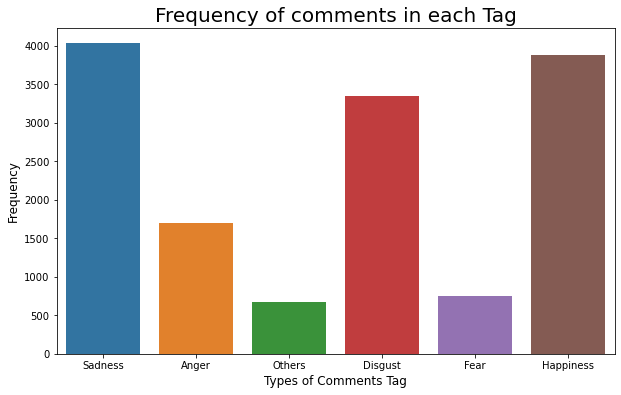

In [221]:
# plotting Frequency of comments in each Tag 
plt.figure(figsize=(10,6))
sb.countplot(data["FinalTag"])
plt.xlabel("Types of Comments Tag", size=12)
plt.ylabel("Frequency", size=12)
plt.title("Frequency of comments in each Tag", size=20)
plt.show()


In [222]:
#each comment's tag percentages in dataset
parcentages=(data['FinalTag'].value_counts()/data['FinalTag'].count())*100
comment_tag=parcentages.index
print("Each Comment's tag Percentages in Dataset\n", parcentages)
# print(type(list(comment_tag)))

Each Comment's tag Percentages in Dataset
 Sadness      28.003331
Happiness    26.969255
Disgust      23.277118
Anger        11.819002
Fear          5.218960
Others        4.712333
Name: FinalTag, dtype: float64


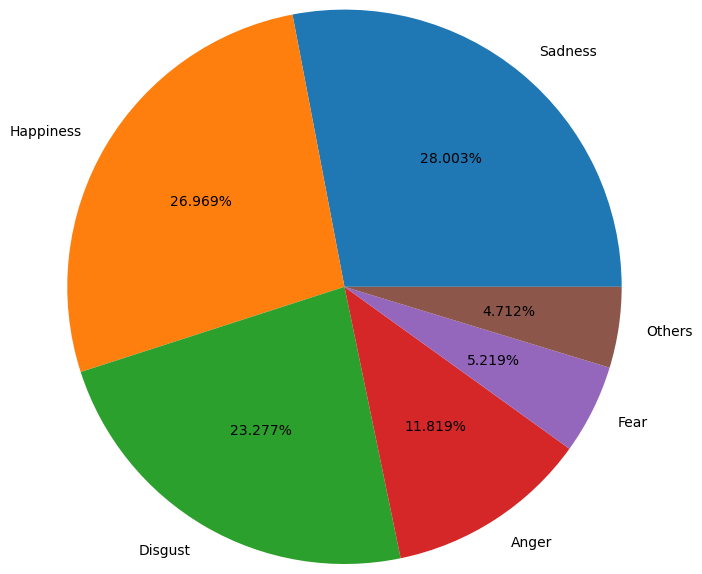

In [ ]:
plt.figure(figsize=(4,3))
plt.pie(parcentages,labels =comment_tag,autopct='%1.3f%%',radius = 3)
plt.show()

In [ ]:
# calculating total word for each comment's tag 
def countWords(df):
  total_words_per_tag=dict.fromkeys(comment_tag,  0)
  total_comments_per_tag=dict.fromkeys(comment_tag,  0)


 
  for ind in df.index:
    tag=df['FinalTag'][ind]
    comment=df['cleaned_comments'][ind]
    total_words_per_tag[tag]=total_words_per_tag.get(tag)+len(comment.split())
    total_comments_per_tag[tag]=total_comments_per_tag.get(tag)+1   

  return  total_words_per_tag,total_comments_per_tag



In [ ]:
# function calling
words_per_Tag, comments_per_tag=countWords(data)

In [ ]:
#calculating total words in dataset
total_words=sum(words_per_Tag.values())

In [ ]:
print("Total number words in dataset:", total_words)
print("Total Words in Each Comment's Tag:")
for tag in words_per_Tag:
  print(tag, ":", words_per_Tag[tag])

Total number words in dataset: 142911
Total Words in Each Comment's Tag:
Sadness : 42108
Happiness : 34079
Disgust : 35389
Anger : 17935
Fear : 7385
Others : 6015


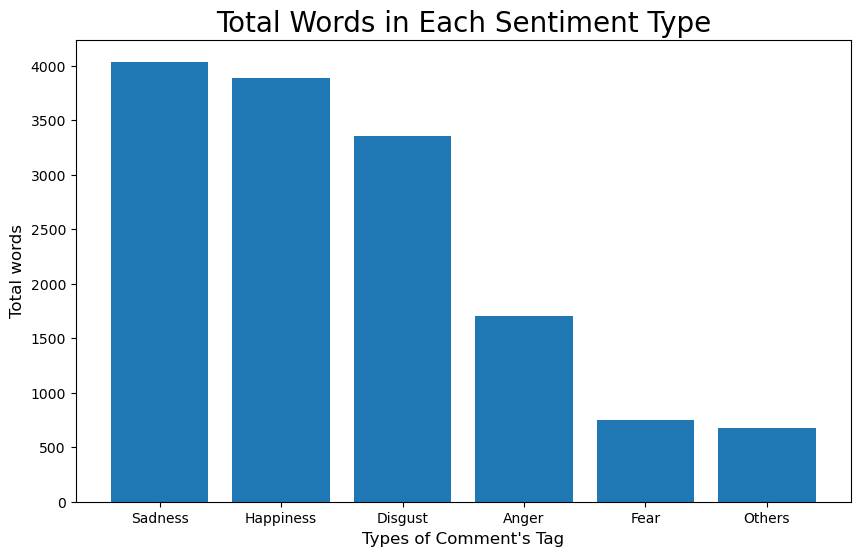

In [ ]:
#ploting total words for each comment's tag
plt.figure(figsize=(10,6))
plt.bar(words_per_Tag.keys(),comments_per_tag.values())
plt.xlabel("Types of Comment's Tag", size=12)
plt.ylabel("Total words", size=12)
plt.title("Total Words in Each Sentiment Type", size=20)
plt.show()

In [ ]:
# calculating average word for each tag
average_word_per_tag=dict.fromkeys(comment_tag,  0)

for tag in comment_tag:
  average_word_per_tag[tag]=round(words_per_Tag[tag]/comments_per_tag[tag])

print("Average Words in Each Comment's Tag:")
for tag in average_word_per_tag:
  print(tag, ":", average_word_per_tag[tag])

Average Words in Each Comment's Tag:
Sadness : 10
Happiness : 9
Disgust : 11
Anger : 11
Fear : 10
Others : 9


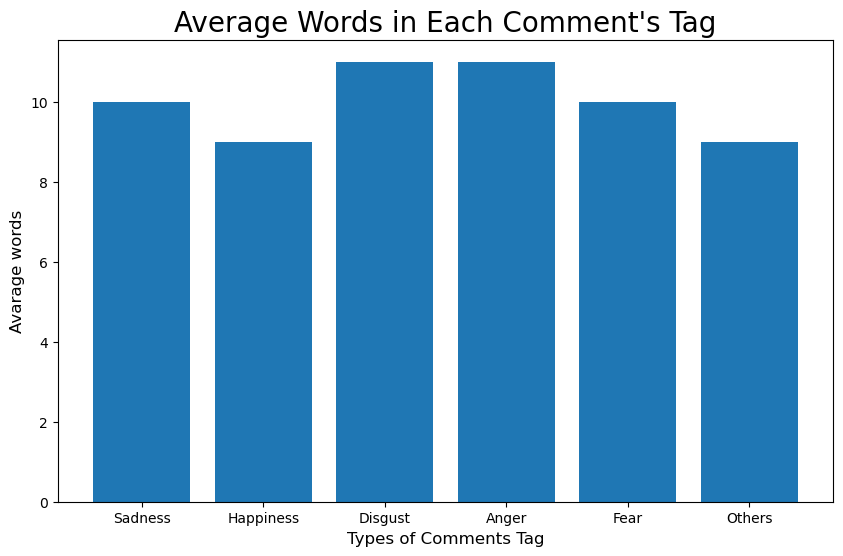

In [ ]:
plt.figure(figsize=(10,6))
plt.bar(average_word_per_tag.keys(),average_word_per_tag.values())
plt.xlabel("Types of Comments Tag", size=12)
plt.ylabel("Avarage words", size=12)
plt.title("Average Words in Each Comment's Tag", size=20)
plt.show()

In [ ]:
#calculating total unique word in dataset
def count_total_uniquewords(df):
  word_list=[]
  for comment in list(df["cleaned_comments"]):
    for word in comment.split():
      word_list.append(word)
 
  # print(len(word_list))
  return word_list, len(np.unique(word_list))

  
    

In [ ]:
#total unique words
word_list, total_unique_words=count_total_uniquewords(data)
print("Total Unique words in Dataset: ",total_unique_words)

Total Unique words in Dataset:  19276


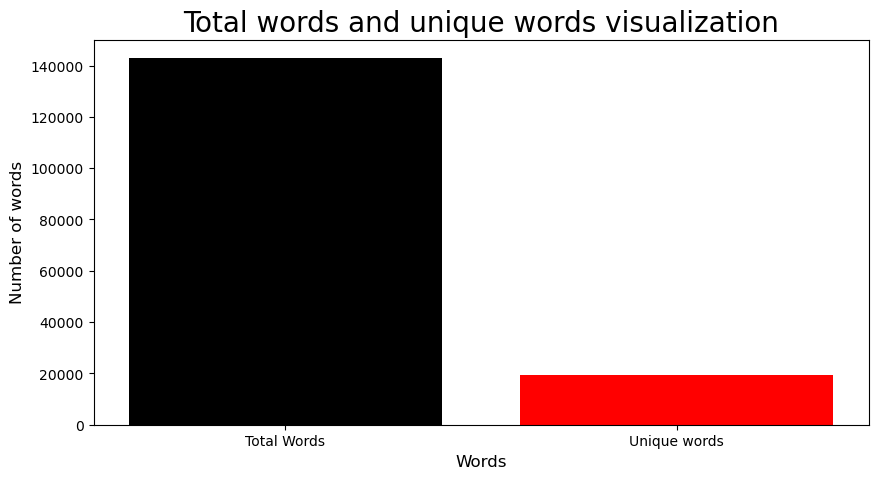

In [ ]:
#ploting total words and unique words in bar chart
plt.figure(figsize=(10,5))
c = ['black', 'red']
plt.bar(["Total Words","Unique words"],[total_words,total_unique_words],color=c)
plt.xlabel("Words", size=12)
plt.ylabel("Number of words", size=12)
plt.title("Total words and unique words visualization", size=20)
plt.show()

In [ ]:
#calculating words frequency
def cal_words_frecuncy():
  counts = dict()
  for word in word_list:
   counts[word] = counts.get(word, 0)+1

  return counts

In [ ]:
words_frecuncy=cal_words_frecuncy()
sorted_words_frecuncy =sorted(words_frecuncy.items(), key= lambda item: item[1],reverse = True)

In [ ]:
print("Top 20 Frequent Word in Dataset:")
for word,freq in sorted_words_frecuncy[:20]:
              print("{} : {}".format(word,freq))

Top 20 Frequent Word in Dataset:
না : 2530
এই : 1511
করে : 1492
আর : 1177
জন্য : 951
কি : 913
হবে : 893
ভালো : 781
করা : 734
মানুষ : 729
ও : 691
আমাদের : 683
হয় : 662
অনেক : 655
থেকে : 631
দেশের : 605
কথা : 605
আছে : 600
একটা : 590
সব : 566


**Comment Length Distribution**

Maximum Comment Size:  86
Minimum Comment Size:  3
Average Comment Size:  9.918176139912555


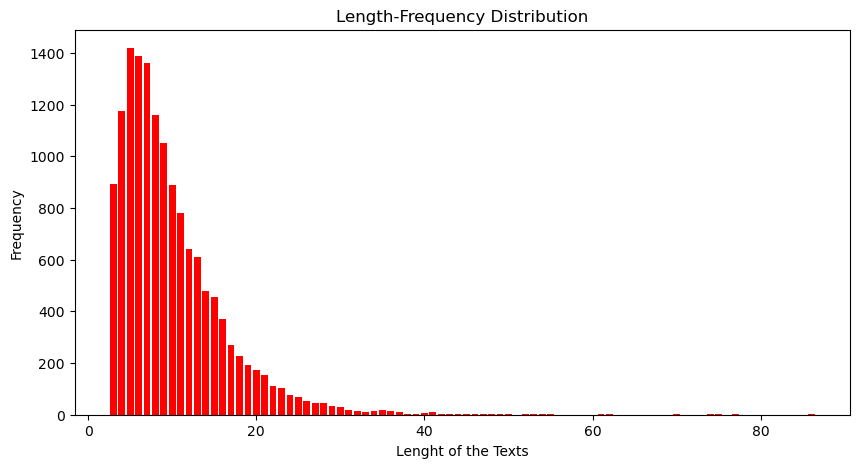

In [ ]:
max_length,min_length,frequency = length_distribution(data["cleaned_comments"])
avarage_length=total_words/total_comments
print("Maximum Comment Size: ", max_length)
print("Minimum Comment Size: ",min_length)
print("Average Comment Size: ", avarage_length)

plt.figure(figsize=(10,5))
plt.bar(frequency.keys(), frequency.values(), color ="r")
plt.xlabel('Lenght of the Texts')
plt.ylabel('Frequency')
plt.title('Length-Frequency Distribution')
plt.show()  

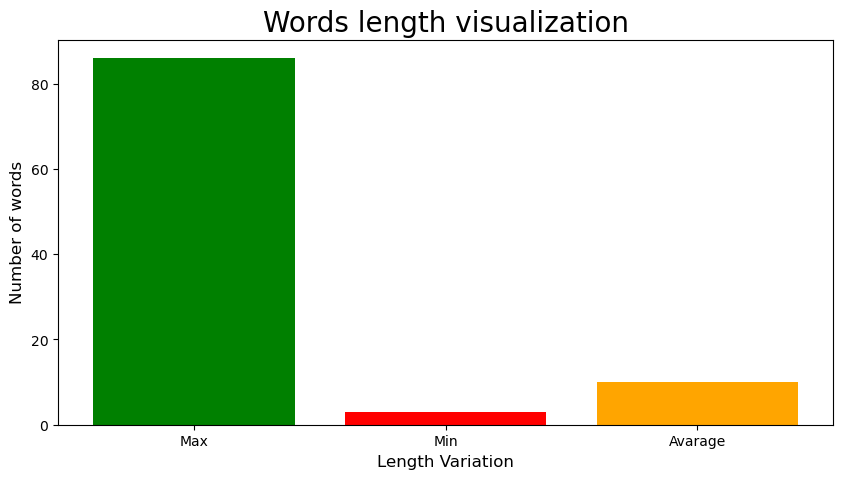

In [ ]:
#ploting length distribution
plt.figure(figsize=(10,5))
c = ['green', 'red','orange']
plt.bar(["Max","Min","Avarage"],[max_length,min_length,avarage_length],color=c)
plt.xlabel("Length Variation", size=12)
plt.ylabel("Number of words", size=12)
plt.title("Words length visualization", size=20)
plt.show()

**Removing comments having less than 3 words**

**Lebel Encoding**

In [ ]:
# not necessary
label_encoder = preprocessing.LabelEncoder()

data['encoded_tag']= label_encoder.fit_transform(data['FinalTag'])
print(data['encoded_tag'].unique())
print(data['FinalTag'].unique())
data

[5 0 4 1 6 2 3]
['Sadness' 'Anger' 'Others' 'Disgust' 'Surprise' 'Fear' 'Happiness']


,Comments,FinalTag,cleaned_comments,length,encoded_tag
0,"বিশ্ববিদ্যালয়ে শিক্ষক রাজনীতি, ছাত্র রাজনীতি ...",Sadness,বিশ্ববিদ্যালয়ে শিক্ষক রাজনীতি ছাত্র রাজনীতি ...,16,5
1,পাকিস্তান যেই তালিকায় থাকে ওই তালিকা আমরা এমনে...,Anger,পাকিস্তান যেই তালিকায় থাকে ওই তালিকা আমরা এমনে...,10,0
2,"সিংগাপুরের সাথে ভারত, পাকিস্তানের তুলনা কেন? আ...",Others,সিংগাপুরের সাথে ভারত পাকিস্তানের তুলনা কেন আ...,20,4
3,আমাদের দেশের শিক্ষা প্রতিষ্ঠানগুলোতে পড়ালেখার...,Sadness,আমাদের দেশের শিক্ষা প্রতিষ্ঠানগুলোতে পড়ালেখার...,16,5
4,আমাদের দেশের শিক্ষা প্রতিষ্ঠান রাজনীতিতে প্রথম...,Disgust,আমাদের দেশের শিক্ষা প্রতিষ্ঠান রাজনীতিতে প্রথম...,12,1
...,...,...,...,...,...
14993,আহারে জীবন কত কঠিন,Sadness,আহারে জীবন কত কঠিন,4,5
14995,"শুধু মাত্র আর্জেন্টিনা নয়, বাংলাদেশ একই পরিস্থ...",Sadness,শুধু মাত্র আর্জেন্টিনা নয় বাংলাদেশ একই পরিস্থ...,7,5
14996,গার্মেন্টস মালিকদের মিথ্যাচারে আমাদের সরকার হয়...,Fear,গার্মেন্টস মালিকদের মিথ্যাচারে আমাদের সরকার হয়...,9,2
14997,জঘন্য একজন মানুষ,Disgust,জঘন্য একজন মানুষ,3,1


**Bag of Words**

In [157]:
#train: validation: test = 80: 10: 10
from sklearn.model_selection import train_test_split
X_train, X_main, y_train, y_main = train_test_split(data['cleaned_comments'], data['FinalTag'], test_size = 0.2, random_state = 0)
X_test, X_val, y_test, y_val= train_test_split(X_main, y_main, test_size = 0.5, random_state = 0)

In [158]:
y_train.value_counts()

Sadness      3225
Happiness    3125
Disgust      2667
Anger        1359
Fear          601
Others        550
Name: FinalTag, dtype: int64

In [159]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(analyzer='word', min_df=1, lowercase=False,
                                          token_pattern=u'[\S]+', tokenizer=None)

X_train=cv.fit_transform(X_train).toarray()
X_test=cv.transform(X_test).toarray()
X_val=cv.transform(X_val).toarray()
# print(X_train.shape)
# print(x.shape)
# print(y.shape)
print(len(cv.get_feature_names()))
# # print(x)
df = pd.DataFrame(data=X_train,columns = cv.get_feature_names())
df

17068


,অ,অংক,অংশ,অংশগ্রহণ,অংশগ্রহন,অংশটি,অংশটুকু,অংশীদার,অংশে,অংশের,...,৮০,৮০০,৮৮,৯,৯টায়,৯বছরে,৯০,৯৫,৯৯,৯৯৯
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11522,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11523,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11524,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11525,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**Implementing Naive Bayes**

In [160]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(11527, 17068)
(11527,)
(1441, 17068)
(1441,)
(1441, 17068)
(1441,)


In [161]:
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB()
model.fit(X_train,y_train)



MultinomialNB()

**Test Score**

In [171]:
test_pred = model.predict(X_test)
bow_test_accuracy_nb= accuracy_score(y_test, test_pred)
bow_test_pressicion_nb=precision_score(y_test, test_pred, average='weighted')
bow_test_f1_score_nb=f1_score(y_test, test_pred,average='weighted')
bow_test_recall_nb=recall_score(y_test, test_pred, average='weighted')

print("Test Accuracy: ",bow_test_accuracy_nb)
print("Test Pression: ",bow_test_pressicion_nb)
print("Test F1 Score: ",bow_test_f1_score_nb)
print("Test Recall: ",bow_test_recall_nb)



Test Accuracy:  0.5454545454545454
Test Pression:  0.5751657522064738
Test F1 Score:  0.5200550102121908
Test Recall:  0.5454545454545454


In [172]:
print("Multinomial Naive Bayes Classification Report on Test Data: \n",classification_report(y_test, test_pred))

Multinomial Naive Bayes Classification Report on Test Data: 
               precision    recall  f1-score   support

       Anger       0.52      0.22      0.31       169
     Disgust       0.46      0.53      0.49       350
        Fear       0.62      0.07      0.12        76
   Happiness       0.73      0.72      0.73       395
      Others       1.00      0.04      0.07        52
     Sadness       0.48      0.68      0.56       399

    accuracy                           0.55      1441
   macro avg       0.64      0.38      0.38      1441
weighted avg       0.58      0.55      0.52      1441



In [33]:
cm=confusion_matrix(y_test, test_pred)
print(cm)

[[ 38  68   1  13   0  49]
 [ 13 187   1  29   0 120]
 [  3  18   5   8   0  42]
 [  9  38   0 284   0  64]
 [  2  20   1   8   2  19]
 [  8  75   0  46   0 270]]


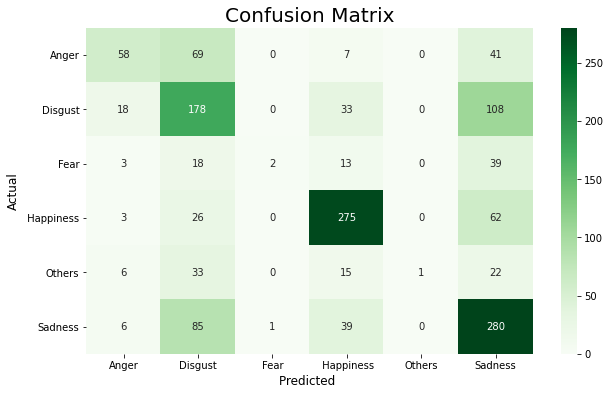

In [173]:
plt.figure(figsize=(10,6))
sb.heatmap(cm, cmap="Greens", annot=True,
           xticklabels=['Anger','Disgust','Fear',' Happiness','Others','Sadness' ],
           yticklabels=['Anger','Disgust','Fear',' Happiness','Others','Sadness'],fmt='d')  


plt.xlabel("Predicted ", size=12)
plt.ylabel("Actual", size=12)
plt.title("Confusion Matrix", size=20)
plt.show()

**SVM on Bag of Words**

In [ ]:
from sklearn.svm import SVC
svm_model = SVC(kernel = 'rbf', gamma=0.1,C= 1000)
svm_model.fit(X_train,y_train)



In [174]:
import pickle
with open('ML_Models/svm_bow_pickle','rb') as f:
 svm_model= pickle.load(f) 

C:\Users\iaman\anaconda3\lib\site-packages\sklearn\base.py:310: UserWarning: Trying to unpickle estimator SVC from version 1.0.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


**Test Score**

In [179]:
test_pred = svm_model.predict(X_test)
bow_test_accuracy_svm= accuracy_score(y_test, test_pred)
bow_test_pressicion_svm =precision_score(y_test, test_pred, average='weighted')
bow_test_f1_score_svm=f1_score(y_test, test_pred,average='weighted')
bow_test_recall_svm=recall_score(y_test, test_pred, average='weighted')

print("Test Accuracy: ",bow_test_accuracy_svm)
print("Test Pression: ",bow_test_pressicion_svm)
print("Test F1 Score: ",bow_test_f1_score_svm)
print("Test Recall: ",bow_test_recall_svm)

Test Accuracy:  0.5322692574600971
Test Pression:  0.53922333358562
Test F1 Score:  0.5212220089594778
Test Recall:  0.5322692574600971


In [180]:
print("SVM Classification Report on Test Data: \n",classification_report(y_test, test_pred))

SVM Classification Report on Test Data: 
               precision    recall  f1-score   support

       Anger       0.48      0.33      0.39       169
     Disgust       0.45      0.49      0.47       350
        Fear       0.61      0.14      0.23        76
   Happiness       0.72      0.70      0.71       395
      Others       0.39      0.13      0.20        52
     Sadness       0.47      0.61      0.53       399

    accuracy                           0.53      1441
   macro avg       0.52      0.40      0.42      1441
weighted avg       0.54      0.53      0.52      1441



In [181]:
cm=confusion_matrix(y_test, test_pred)
print(cm)

[[ 55  55   1  20   0  38]
 [ 30 173   1  31   4 111]
 [  6   8  11   9   0  42]
 [  8  45   0 276   2  64]
 [  2  17   0   4   7  22]
 [ 14  88   5  42   5 245]]


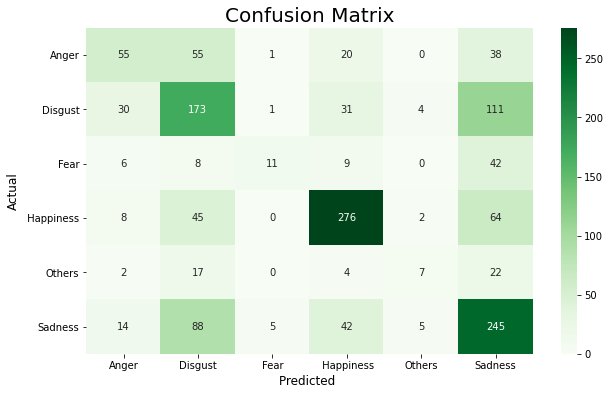

In [182]:
plt.figure(figsize=(10,6))
sb.heatmap(cm, cmap="Greens", annot=True,
           xticklabels=['Anger','Disgust','Fear',' Happiness','Others','Sadness' ],
           yticklabels=['Anger','Disgust','Fear',' Happiness','Others','Sadness'],fmt='d')  


plt.xlabel("Predicted ", size=12)
plt.ylabel("Actual", size=12)
plt.title("Confusion Matrix", size=20)
plt.show()

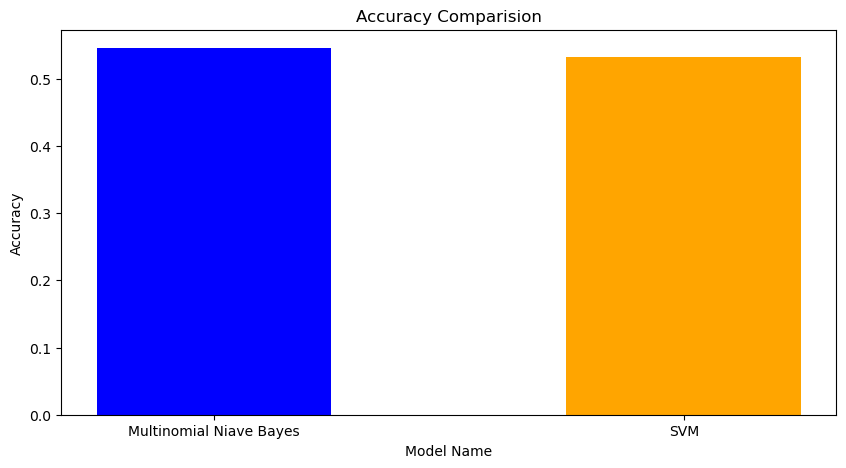

In [ ]:
#bar chart using matplotlib
x_axis = ['Multinomial Niave Bayes', 'SVM']
y_axis = [bow_test_accuracy_nb, bow_test_accuracy_svm]

fig = plt.figure(figsize=(10, 5))

c=['blue','orange']
plt.bar(x_axis, y_axis, color=c,
        width=.5)
plt.xlabel("Model Name")
plt.ylabel("Accuracy")
plt.title("Accuracy Comparision")
plt.show()

In [ ]:
import pickle
with open('ML_Models/svm_bow_pickle','wb') as f:
  pickle.dump(svm_model,f)  

**TF-IDF**

In [347]:
#train: validation: test = 80: 10: 10
from sklearn.model_selection import train_test_split
X_train, X_main, y_train, y_main = train_test_split(data['cleaned_comments'], data['FinalTag'], test_size = 0.2, random_state = 0)
X_test, X_val, y_test, y_val= train_test_split(X_main, y_main, test_size = 0.5, random_state = 0)

In [348]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(use_idf=True,tokenizer=lambda x: x.split()) 
x_train_tf_idf = tfidf.fit_transform(X_train).toarray()
x_test_tf_idf= tfidf.transform(X_test).toarray()
x_val_tf_idf=tfidf.transform(X_val).toarray()
print(x_train_tf_idf.shape)
# print(x_1.shape)
# print(y_1.shape)
print(tfidf.get_feature_names())
df = pd.DataFrame(data=x_train_tf_idf,columns = tfidf.get_feature_names())
df

(11527, 17068)
['অ', 'অংক', 'অংশ', 'অংশগ্রহণ', 'অংশগ্রহন', 'অংশটি', 'অংশটুকু', 'অংশীদার', 'অংশে', 'অংশের', 'অই', 'অকটেন', 'অকটেনের', 'অকথ্য', 'অকপটে', 'অকল্পনীয়', 'অকল্পনীয়', 'অকাজ', 'অকাজের', 'অকার্যকর', 'অকাল', 'অকালে', 'অকৃতজ্ঞ', 'অকৃতজ্ঞতার', 'অকৃত্রিম', 'অকৃপণ', 'অকে', 'অকেজো', 'অকেটন', 'অক্লান্ত', 'অক্ষয়', 'অক্ষরে', 'অক্ষুন্ন', 'অক্সাইড', 'অক্সিজেন', 'অখন্ড', 'অখন্ডতা', 'অখাদ্য', 'অখ্রিষ্টান', 'অগণিত', 'অগনিত', 'অগোছালো', 'অগ্নিকাণ্ডের', 'অগ্নিকান্ডে', 'অগ্নিকান্ডের', 'অগ্নিয়াস্ত্র', 'অগ্নিসংযোগ', 'অগ্রগতি', 'অগ্রগতির', 'অগ্রযাত্রাকে', 'অগ্রসর', 'অগ্রহণযোগ্য', 'অগ্রহনযোগ্য', 'অগ্রাধিকার', 'অগ্রাহ্য', 'অগ্লি', 'অঘোষিত', 'অঙ্গনে', 'অঙ্গীকার', 'অঙ্গে', 'অচল', 'অচিরে', 'অচিরেই', 'অচেনা', 'অচ্যতার', 'অজস্র', 'অজানা', 'অজানায়', 'অজান্তে', 'অজান্তেই', 'অজারকতা', 'অজুহাত', 'অজুহাতে', 'অজুহাতের', 'অজ্ঞ', 'অজ্ঞতা', 'অজ্ঞান', 'অঝোরে', 'অঞ্চল', 'অঞ্চলে', 'অঞ্চলের', 'অটল', 'অটুট', 'অটো', 'অটোপাশ', 'অটোপাস', 'অটোমেটিক', 'অটোরিকশা', 'অডার', 'অঢেল', 'অত', 'অতন্ত', 'অতন্ত্য', 'অতবা', 'অতরিক্ত'

,অ,অংক,অংশ,অংশগ্রহণ,অংশগ্রহন,অংশটি,অংশটুকু,অংশীদার,অংশে,অংশের,...,৮০,৮০০,৮৮,৯,৯টায়,৯বছরে,৯০,৯৫,৯৯,৯৯৯
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11522,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11523,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11524,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11525,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Train Test Validation Spliting**

In [349]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(11527,)
(11527,)
(1441,)
(1441,)
(1441,)
(1441,)


**Naive Bayes on TF-IDF**

In [186]:
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB()
model.fit(x_train_tf_idf,y_train)

MultinomialNB()

**Test Score**

In [191]:
test_pred = model.predict(x_test_tf_idf)
tfidf_mnb_accurary=accuracy_score(y_test, test_pred)
tfidf_mnb_pressicion=precision_score(y_test, test_pred, average='weighted')
tfidf_mnb_f1_score=f1_score(y_test, test_pred,average='weighted')
tfidf_mnb_recall=recall_score(y_test, test_pred, average='weighted')

print("Test Accuracy: ",tfidf_mnb_accurary)
print("Test Pression: ",tfidf_mnb_pressicion)
print("Test F1 Score: ",tfidf_mnb_f1_score)
print("Test Recall: ",tfidf_mnb_recall)

Test Accuracy:  0.5225537820957669
Test Pression:  0.5266063078618772
Test F1 Score:  0.47633148995099045
Test Recall:  0.5225537820957669


C:\Users\iaman\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [192]:
print("Multinomial Naive Bayes Classification Report on Training Data: \n",classification_report(y_test, test_pred))

Multinomial Naive Bayes Classification Report on Training Data: 
               precision    recall  f1-score   support

       Anger       0.85      0.10      0.18       169
     Disgust       0.50      0.42      0.46       350
        Fear       0.00      0.00      0.00        76
   Happiness       0.68      0.73      0.71       395
      Others       0.00      0.00      0.00        52
     Sadness       0.42      0.75      0.54       399

    accuracy                           0.52      1441
   macro avg       0.41      0.33      0.31      1441
weighted avg       0.53      0.52      0.48      1441



C:\Users\iaman\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\iaman\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\iaman\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [193]:
cm=confusion_matrix(y_test, test_pred)
print(cm)

[[ 17  57   0  19   0  76]
 [  0 147   0  40   0 163]
 [  0   5   0  11   0  60]
 [  1  21   0 290   0  83]
 [  0  20   0   9   0  23]
 [  2  42   0  56   0 299]]


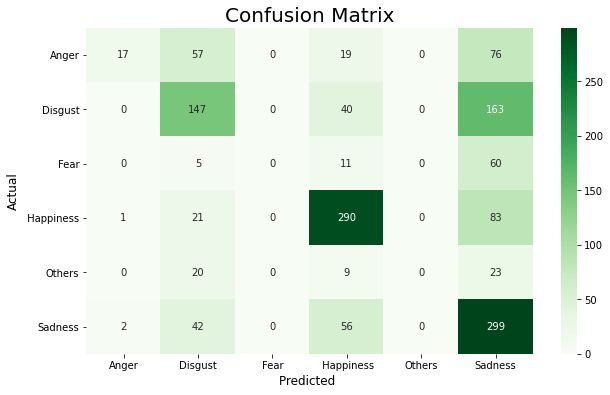

In [194]:
plt.figure(figsize=(10,6))
sb.heatmap(cm, cmap="Greens", annot=True,
           xticklabels=['Anger','Disgust','Fear',' Happiness','Others','Sadness' ],
           yticklabels=['Anger','Disgust','Fear',' Happiness','Others','Sadness'], fmt='d')  


plt.xlabel("Predicted ", size=12)
plt.ylabel("Actual", size=12)
plt.title("Confusion Matrix", size=20)
plt.show()

**SVM on TF-IDF**

In [ ]:
#Test-3 
from sklearn.svm import SVC
svm_model = SVC(kernel = 'rbf', gamma=0.5,C= 2000)
svm_model.fit(x_train_tf_idf,y_train)

SVC(C=2000, gamma=0.5)

In [352]:
import pickle
with open('ML_Models/svm_tfidf_pickle','rb') as f:
 svm_model= pickle.load(f) 

C:\Users\iaman\anaconda3\lib\site-packages\sklearn\base.py:310: UserWarning: Trying to unpickle estimator SVC from version 1.0.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


**Test Score**

In [357]:
test_pred = svm_model.predict(x_test_tf_idf)
tfidf_svm_test_accurary=accuracy_score(y_test, test_pred)
tfidf_svm_test_pressicion=precision_score(y_test, test_pred, average='weighted')
tfidf_svm_test_f1_score=f1_score(y_test, test_pred,average='weighted')
tfidf_svm_test_recall=recall_score(y_test, test_pred, average='weighted')

print("Test Accuracy: ",tfidf_svm_test_accurary)
print("Test Pression: ",tfidf_svm_test_pressicion)
print("Test F1 Score: ",tfidf_svm_test_f1_score)
print("Test Recall: ",tfidf_svm_test_recall)

Test Accuracy:  0.5392088827203331
Test Pression:  0.5452585487942536
Test F1 Score:  0.5320520776749502
Test Recall:  0.5392088827203331


In [358]:
print("SVM Classification Report on Test Data: \n",classification_report(y_test, test_pred))

SVM Classification Report on Test Data: 
               precision    recall  f1-score   support

       Anger       0.42      0.36      0.38       169
     Disgust       0.44      0.49      0.46       350
        Fear       0.73      0.25      0.37        76
   Happiness       0.72      0.72      0.72       395
      Others       0.39      0.13      0.20        52
     Sadness       0.50      0.60      0.54       399

    accuracy                           0.54      1441
   macro avg       0.53      0.42      0.45      1441
weighted avg       0.55      0.54      0.53      1441



In [359]:
cm=confusion_matrix(y_test, test_pred)
print(cm)

[[ 60  59   1  16   1  32]
 [ 44 170   0  33   5  98]
 [  5   9  19   8   0  35]
 [ 11  44   1 283   1  55]
 [  2  19   0   6   7  18]
 [ 22  85   5  45   4 238]]


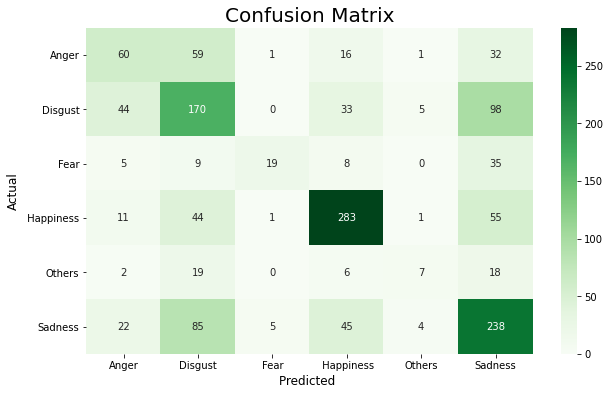

In [360]:
plt.figure(figsize=(10,6))
sb.heatmap(cm, cmap="Greens", annot=True,
           xticklabels=['Anger','Disgust','Fear',' Happiness','Others','Sadness' ],
           yticklabels=['Anger','Disgust','Fear',' Happiness','Others','Sadness'],fmt='d')  


plt.xlabel("Predicted ", size=12)
plt.ylabel("Actual", size=12)
plt.title("Confusion Matrix", size=20)
plt.show()

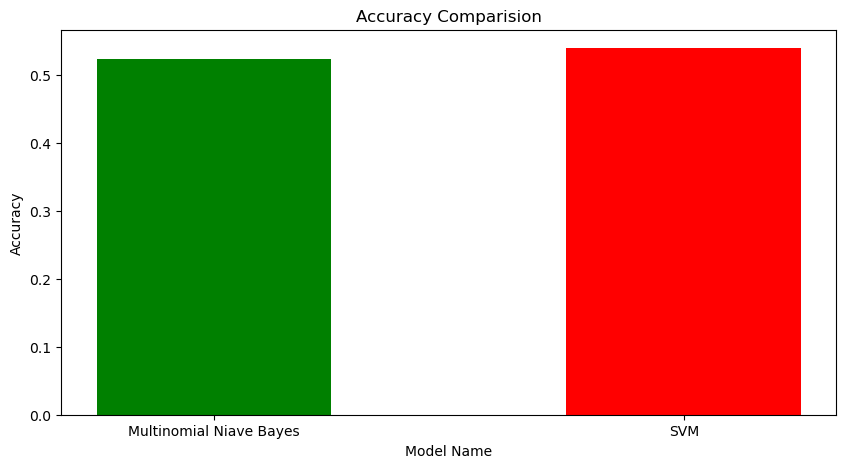

In [ ]:
#bar chart using matplotlib
x_axis = ['Multinomial Niave Bayes', 'SVM']
y_axis = [tfidf_mnb_accurary, tfidf_svm_test_accurary]

fig = plt.figure(figsize=(10, 5))

c=['green','red']
plt.bar(x_axis, y_axis, color=c,
        width=.5)
plt.xlabel("Model Name")
plt.ylabel("Accuracy")
plt.title("Accuracy Comparision")
plt.show()

In [ ]:
import pickle
with open('ML_Models/svm_tfidf_pickle','wb') as f:
    pickle.dump(svm_model,f)

**Glove Vectors**

In [235]:
glove_vectors=dict()
with open('bn_glove.39M.300d.txt', 'r',encoding='utf8') as f:
  for line in f:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:], "float32")
    glove_vectors[word] = vector
 

In [236]:
# glove_vectors.keys()

In [237]:
len(glove_vectors.keys())

178153

In [238]:
print(glove_vectors['শিক্ষক'])
print(glove_vectors['আমাদের'])

[ 0.056722 -0.965338  0.127817 -0.447545 -0.191535 -0.61716  -0.114502
 -0.292194  0.390322  0.569249 -1.128244 -0.028687  0.125765 -0.571056
 -0.25704  -0.581712  0.131531  0.262273  0.923596  0.481491  0.127045
  0.051868 -0.290623 -0.679539  0.382784  0.402894  0.103682  0.854739
 -0.058631  1.023818 -0.033157 -0.901606  0.05905  -0.255645  0.552068
  0.318846  0.189177  0.206485 -0.038366 -0.157999 -0.289474 -0.082947
 -1.101873  0.541182 -0.316529  0.485452  0.120027  0.814312  0.161053
  0.399553  0.091411 -0.071105 -0.194878  0.017704 -0.02413   0.281282
  0.829693  0.217575 -0.361491  0.204021  0.546411  0.170403  0.009369
 -0.460455 -0.378666 -0.451039  0.547619 -0.404904  0.379756 -0.740009
 -0.280062 -0.082787  0.933897 -0.511237 -0.650225  0.442801  0.378796
  0.262488  0.4504   -0.363852  0.029308 -1.050565  0.317201  0.488549
 -0.249817 -1.826455  0.603849  0.745679 -0.346589 -0.245405 -0.47148
 -0.356642 -0.198253 -0.460372 -0.482909 -0.932945  0.149863  0.140925
 -0.214

In [239]:
text2vec_data=[]

In [240]:
# covert each sentence into 300dim vector
def sentence2Vector(corpus):
  
  for entity in corpus:
    sentence= np.zeros(300)
    entity_words=entity.split()
    
    for word in entity_words:
      if word in glove_vectors.keys():
        sentence = sentence + glove_vectors[word]
    
    text2vec_data.append(sentence)
  
    

In [241]:
sentence2Vector(data['cleaned_comments'].tolist())

In [242]:
x = np.array(text2vec_data)

In [243]:
x.shape

(14409, 300)

In [244]:
x[0]

array([  1.609751  ,  -1.03640798,   2.27732709,  -5.05959205,
         0.29872202,  -3.554662  ,  -0.21348102,   2.14500902,
        -4.359326  ,   1.87750192, -10.56484715,  -4.8460601 ,
         1.09087794,  -4.24842406,   0.28560099,   0.30425699,
        -1.570001  ,   2.77380696,   3.26367706,  -0.86194595,
         1.48945098,  -1.80394603,  -0.94121403,  -3.71549497,
         1.25263405,   2.88108899,   6.08908411,   2.18757504,
         1.08912496,   1.05738097,  -1.16838005,  -2.72229403,
        -2.21672303,  -3.30780906,   0.49366099,  -3.98456604,
        -0.276085  ,   0.694403  ,   2.26747901,  -4.88857196,
         2.56881498,  -3.85211102,  -1.08454403,  -0.94533202,
         2.06954602,   2.45659004,   9.72663205,   5.60311592,
         1.71258306,   1.17408696,   1.71784101,  -1.06655795,
         0.31665598,   1.33673001,   0.05111999,   5.62972697,
        -0.20852493,   1.41882496,   4.45277401,  -2.09052401,
         1.90923203,   0.44473702,   0.05383001,  -2.70

**Neural Neywork Model**

In [363]:
from sklearn.model_selection import train_test_split
X_train, X_main, y_train, y_main = train_test_split(data['cleaned_comments'], data['FinalTag'], test_size = 0.2, random_state = 0)
X_test, X_val, y_test, y_val= train_test_split(X_main, y_main, test_size = 0.5, random_state = 0)

from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
y_train= label_encoder.fit_transform(y_train)
y_test= label_encoder.fit_transform(y_test)
y_val=label_encoder.fit_transform(y_val)

from sklearn.utils.class_weight import compute_class_weight
weights_compute = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(y_train),
                                        y = y_train)
weights_compute
sklearn_weights = dict(enumerate(weights_compute))
sklearn_weights




import keras
y_train= keras.utils.to_categorical(y_train,6)
y_test=keras.utils.to_categorical(y_test,6)
y_val=keras.utils.to_categorical(y_val,6)

In [366]:
sklearn_weights

{0: 1.4136620063772383,
 1: 0.720347456567929,
 2: 3.196616749861342,
 3: 0.6147733333333333,
 4: 3.493030303030303,
 5: 0.5957105943152454}

In [367]:
pip install Keras-Preprocessing

In [368]:
from keras import preprocessing
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
tokenizer=Tokenizer()
tokenizer.fit_on_texts(X_train)
print(len(tokenizer.word_index))
# print(tokenizer.word_index)

17068


In [369]:
maximum_length=128

In [370]:
X_train= tokenizer.texts_to_sequences(X_train)
X_test=tokenizer.texts_to_sequences(X_test)
X_val=tokenizer.texts_to_sequences(X_val)

X_train=pad_sequences(X_train,padding='post',maxlen=maximum_length)
X_test=pad_sequences(X_test,padding='post',maxlen=maximum_length)
X_val=pad_sequences(X_val,padding='post',maxlen=maximum_length)

In [371]:
vocab_size  = len(tokenizer.word_index) +1
vocab_size

17069

In [372]:
word_vector_matrix = np.zeros((vocab_size, 300))
c=0
for word, index in tokenizer.word_index.items():
   vector = glove_vectors.get(word)
   if vector is not None:
     word_vector_matrix[index] = vector

   else:
     c+=1
print("Missing:", c)


Missing: 3751


In [373]:
print("***Train Data***")
print(len(X_train))
print(len(y_train))

print("***Test Data***")
print(len(X_test))
print(len(y_test))

print("***Validation Data***")
print(len(y_val))
print(len(y_val))

***Train Data***
11527
11527
***Test Data***
1441
1441
***Validation Data***
1441
1441


** ## GRU**

In [121]:
# Model1

from sklearn.utils import class_weight
from keras.models import Sequential
from keras.layers import Dense,Flatten,Embedding,Activation, Dropout,LSTM, Bidirectional,GRU,SpatialDropout1D
from keras.optimizers import Adam
from keras import regularizers
from keras.callbacks import EarlyStopping

vec_size = 300


model = Sequential()
model.add(Embedding(input_dim=vocab_size,output_dim=vec_size, input_length=maximum_length, weights = [word_vector_matrix],
                    trainable = False))
model.add(SpatialDropout1D(0.3))
model.add(Bidirectional(GRU(128, dropout=0.2,return_sequences=True)))
model.add(Bidirectional(GRU(64, dropout=0.2,return_sequences=True)))
model.add(Bidirectional(GRU(32, dropout=0.3)))
model.add(Dense(6, activation='softmax'))

# compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy',keras.metrics.Precision()])


print(model.summary())

history=model.fit(X_train, y_train, epochs = 3000, validation_data = (X_val, y_val),
          callbacks=[EarlyStopping(monitor='val_accuracy',patience=5, verbose=1, min_delta=0.0001)])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 128, 300)          5120700   
                                                                 
 spatial_dropout1d (SpatialD  (None, 128, 300)         0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 128, 256)         330240    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128, 128)         123648    
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 64)               31104     
 nal)                                                   

In [125]:
model.save('DeepLearning_Models/Model1.h5')

In [122]:
model.evaluate(X_test,y_test)

46/46 [==============================] - 5s 101ms/step - loss: 1.4651 - accuracy: 0.5260 - precision: 0.5669


[1.4650932550430298, 0.5260235667228699, 0.5669160485267639]

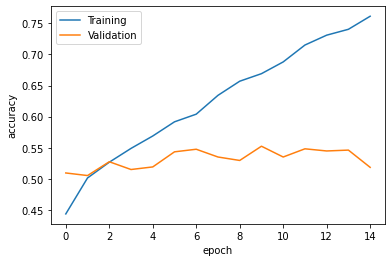

In [123]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Training', 'Validation'])
plt.show()

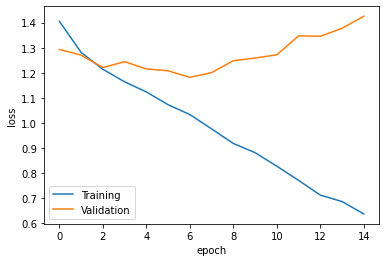

In [124]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Training', 'Validation'])
plt.show()

In [262]:
import keras
model=keras.models.load_model('DeepLearning_Models/Model1.h5')

In [263]:
target_names=['Anger','Disgust','Fear','Happiness','Others','Sadness' ]

In [264]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
y_test_arg=np.argmax(y_test,axis=1)
test_predicted = np.argmax(model.predict(X_test),axis=1)
print('Bidirectional GRU Classification Report')
print(classification_report(y_test_arg, test_predicted,target_names=target_names))

46/46 [==============================] - 9s 125ms/step
Bidirectional GRU Classification Report
              precision    recall  f1-score   support

       Anger       0.40      0.43      0.41       169
     Disgust       0.46      0.40      0.43       350
        Fear       0.44      0.29      0.35        76
   Happiness       0.73      0.75      0.74       395
      Others       0.18      0.31      0.23        52
     Sadness       0.52      0.53      0.53       399

    accuracy                           0.53      1441
   macro avg       0.45      0.45      0.45      1441
weighted avg       0.53      0.53      0.53      1441



In [265]:
print("Testing Recall", recall_score(y_test_arg, test_predicted, average='weighted'))
print("Testing Precission",  precision_score(y_test_arg, test_predicted, average='weighted'))
print("Testing f1_score", f1_score(y_test_arg, test_predicted,average='weighted'))

Testing Recall 0.5260235947258848
Testing Precission 0.531405156279858
Testing f1_score 0.5265960026752413


In [266]:
cm=confusion_matrix(y_test_arg, test_predicted)
print(cm)

[[ 72  42   3  15  10  27]
 [ 54 140   6  33  22  95]
 [  6  12  22   7   5  24]
 [ 10  24   2 295  19  45]
 [  3  16   0  10  16   7]
 [ 37  69  17  45  18 213]]


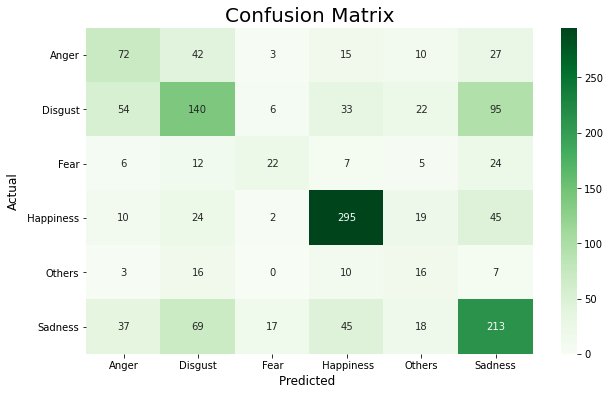

In [267]:
plt.figure(figsize=(10,6))
sb.heatmap(cm, cmap="Greens", annot=True,
           xticklabels=['Anger','Disgust','Fear',' Happiness','Others','Sadness'],
           yticklabels=['Anger','Disgust','Fear',' Happiness','Others','Sadness'],fmt='d')  


plt.xlabel("Predicted ", size=12)
plt.ylabel("Actual", size=12)
plt.title("Confusion Matrix", size=20)
plt.show()

# LSTM

In [ ]:
# LSTM Model1

from sklearn.utils import class_weight
from keras.models import Sequential
from keras.layers import Dense,Flatten,Embedding,Activation, Dropout,LSTM, Bidirectional,GRU,SpatialDropout1D
from keras.optimizers import Adam
from keras import regularizers
from keras.callbacks import EarlyStopping

vec_size = 300


model = Sequential()
model.add(Embedding(input_dim=vocab_size,output_dim=vec_size, input_length=maximum_length, weights = [word_vector_matrix],
                    trainable = False))
model.add(SpatialDropout1D(0.3))
model.add(Bidirectional(LSTM(128, dropout=0.2,return_sequences=True)))
model.add(Bidirectional(LSTM(64, dropout=0.2,return_sequences=True)))
model.add(Bidirectional(LSTM(32, dropout=0.3)))
model.add(Dense(6, activation='softmax'))

# compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy',keras.metrics.Precision()])


print(model.summary())

history=model.fit(X_train, y_train, epochs = 3000, validation_data = (X_val, y_val),
          callbacks=[EarlyStopping(monitor='val_accuracy',patience=5, verbose=1, min_delta=0.0001)])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 128, 300)          5120700   
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 128, 300)         0         
 lDropout1D)                                                     
                                                                 
 bidirectional_3 (Bidirectio  (None, 128, 256)         439296    
 nal)                                                            
                                                                 
 bidirectional_4 (Bidirectio  (None, 128, 128)         164352    
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 64)               41216     
 nal)                                                 

In [ ]:
model.save('DeepLearning_Models(LSTM)/LSTM_Model1.h5')

In [ ]:
model.evaluate(X_test,y_test)

46/46 [==============================] - 4s 80ms/step - loss: 1.2014 - accuracy: 0.5357 - precision_1: 0.6276


[1.20139741897583, 0.5357390642166138, 0.6276488304138184]

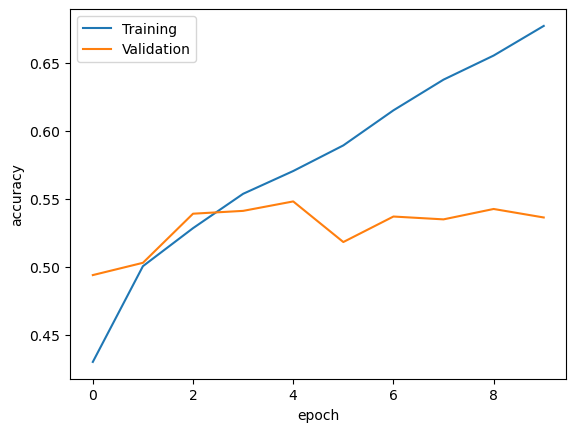

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Training', 'Validation'])
plt.show()


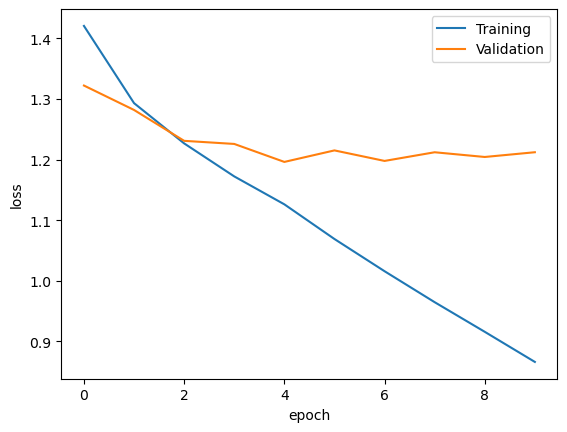

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Training', 'Validation'])
plt.show()

In [281]:
import keras
model=keras.models.load_model('DeepLearning_Models(LSTM)/LSTM_Model1.h5')

In [282]:
target_names=['Anger','Disgust','Fear','Happiness','Others','Sadness' ]

In [283]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
y_test_arg=np.argmax(y_test,axis=1)
test_predicted = np.argmax(model.predict(X_test),axis=1)
print('Bidirectional LSTM Classification Report')
print(classification_report(y_test_arg, test_predicted,target_names=target_names))

46/46 [==============================] - 10s 172ms/step
Bidirectional LSTM Classification Report
              precision    recall  f1-score   support

       Anger       0.37      0.33      0.34       169
     Disgust       0.45      0.55      0.49       350
        Fear       0.57      0.28      0.37        76
   Happiness       0.70      0.72      0.71       395
      Others       0.28      0.25      0.26        52
     Sadness       0.55      0.52      0.53       399

    accuracy                           0.54      1441
   macro avg       0.49      0.44      0.45      1441
weighted avg       0.54      0.54      0.53      1441



In [284]:
print("Testing Recall", recall_score(y_test_arg, test_predicted, average='weighted'))
print("Testing Precission",  precision_score(y_test_arg, test_predicted, average='weighted'))
print("Testing f1_score", f1_score(y_test_arg, test_predicted,average='weighted'))

Testing Recall 0.5357390700902152
Testing Precission 0.5366183875373658
Testing f1_score 0.5319785979208369


In [285]:
cm=confusion_matrix(y_test_arg, test_predicted)
print(cm)

[[ 55  63   2  23   2  24]
 [ 43 191   3  36   8  69]
 [  9  18  21   3   3  22]
 [ 14  44   1 286   8  42]
 [  2  18   0  10  13   9]
 [ 27  91  10  52  13 206]]


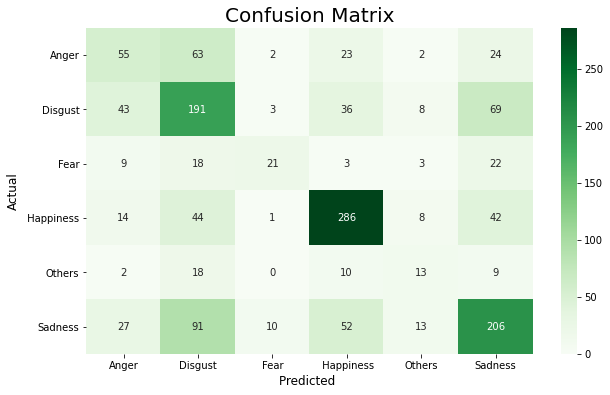

In [286]:
plt.figure(figsize=(10,6))
sb.heatmap(cm, cmap="Greens", annot=True,
           xticklabels=['Anger','Disgust','Fear',' Happiness','Others','Sadness'],
           yticklabels=['Anger','Disgust','Fear',' Happiness','Others','Sadness'],fmt='d')  


plt.xlabel("Predicted ", size=12)
plt.ylabel("Actual", size=12)
plt.title("Confusion Matrix", size=20)
plt.show()